In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from scipy import stats
import datetime as dt
import random as rnd
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.plotting import ColumnDataSource,output_notebook
from bokeh.models import HoverTool
import math
from scipy.spatial.distance import euclidean

In [16]:
n_of_customers=int(input('The number of customers : '))
n_of_couriers=int(input('The number of couriers : '))
n_of_warehouses=int(input('The number of warehouses : '))
average_order_waiting_limit=int(input('Average Order waiting limit (in min) : '))*60

order_prob=0.000005    #Order probabiities are distributed with Poisson (Lambda = 2 days)
order_queue=pd.DataFrame({"Customers_in_queue":[]})


def calculateDistance(x1,y1,x2,y2):               #Calculates the hypotenuse distance of two points
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

#Control every second whether an order was given or not.
def Control_orders(objects,time):  #takes the exact time and calculate whether that customer give order at that time.
    customer_ids_gave_order=[]
    for i in range(n_of_customers):
        if objects[i].order_time_hist != []:
            if objects[i].order_time_hist[-1] == time :
                customer_ids_gave_order.append(objects[i].cust_id)
            
    return customer_ids_gave_order

#Find the available courier in a specific time.
def available_couriers(cour_objects):
    available_ones=[]
    for cour in range(n_of_couriers):
        if(cour_objects[cour].availability == 1) & (cour_objects[cour].to_warehouse == 0):
            available_ones.append(cour_objects[cour].cour_id)
    return available_ones


#If a courier is available and there is not any order then the couriers are sent to the nearest warehouse to wait the next order.
def nearest_warehouse(my_x,my_y):
    pt=None
    best_dist=9999999
    for num in range(n_of_warehouses):
        hypotenuse_distance=calculateDistance(warehouse_objects[num].location_x,warehouse_objects[num].location_y,my_x,my_y)
        if hypotenuse_distance< best_dist:
            best_dist= hypotenuse_distance
            pt=num
    return pt


def order_served_time(order_placement,order_received):
    return (order_received-order_placement)
    

#Finds the most suitable courier for a specific customer order in a specific time
def finding_the_best_courier(custom,ava_cour):
    total_times_per_courier=[[0 for i in range(2)] for j in range(len(ava_cour))]
    for cours in range(len(ava_cour)):
        total_times_per_warehouses=[]
        for whs in range(n_of_warehouses):
            taking_from_wh=calculateDistance(warehouse_objects[whs].location_x,warehouse_objects[whs].location_y,courier_objects[ava_cour[cours]].location_x,courier_objects[ava_cour[cours]].location_y)
            delivery=calculateDistance(warehouse_objects[whs].location_x,warehouse_objects[whs].location_y,custom.location_x,custom.location_y)
            total_times_per_warehouses.append(taking_from_wh+delivery)
        total_times_per_courier[cours]=(min(total_times_per_warehouses)),total_times_per_warehouses.index(min(total_times_per_warehouses))
    total_times_per_courier=pd.DataFrame(total_times_per_courier)
    cour_ind=rnd.choice(np.where(total_times_per_courier[0] == np.array(total_times_per_courier[0]).min())[0])
    best_warehouse=total_times_per_courier[1][cour_ind]
    return cour_ind,best_warehouse
    

    
def points_distance(point,other_points):
    return [ euclidean(point,other_points[j]) for j in range(len(other_points)) ]

def maximum_distance(list_df):
    ds_max = max(list_df)
    idx = list_df.index(ds_max)
    return pts[idx]
        


class Warehouses:
    def __init__(self,wh_id):
        self.wh_id=wh_id
        self.location_x=0   #if one warehouse is selected, it is placed to the center of the area, but if there are more than 
        self.location_y=0   #one warehouse than the warehouses are placed with distance maximizing condition.
    
class Customers:
    def __init__(self,cust_id):
        self.cust_id=cust_id
        self.location_x=rnd.randint(-10000, 10000)
        self.location_y=rnd.randint(-10000, 10000)
        self.order_situation=0
        self.order_waiting_time=np.random.normal(average_order_waiting_limit, 100, 1)[0]
        self.order_time_hist=[]
        self.order_arrival_time=[]
        self.Rating=[]
        
        
    def give_order(self,time):
        if (rnd.random()<=order_prob) & (self.order_situation == 0) : #One can not give the second order 
            self.order_situation = 1                                  # before the last order is satisfied.
            self.order_time_hist.append(time)
            print('Customer {} gave order'.format(self.cust_id))
            
    def give_rating(self,order_time,arrival_time):
        if(arrival_time-order_time<=self.order_waiting_time):
            rating=5-(5*((arrival_time-order_time)/self.order_waiting_time))
            if rating >4:
                rating=5
            else:
                rating +=1
            self.Rating.append(rating)
        else:
            self.Rating.append(1)
    
class Couriers:
    def __init__(self,cour_id):
        self.cour_id=cour_id
        if(rnd.random()<0.2):
            self.vehicle_type ='car'
            self.capacity = 15
        else:
            self.vehicle_type = 'motorbike'
            self.capacity = 3
            
        self.speed = np.random.normal(0.5, 0.05, 1)[0]
        self.arrival_time=None                #the time between order accepting and warehouse arrival
        self.order_distribution_time=None     #the time between package taken and customer distribution
        self.order_taken_time=[]              #the time a courier accepts the order.
        self.choosed_customer=None            #the customer for ordering
        self.choosed_warehouse=None           #the warehouse that supplies the ordered product for a courier.
        self.connected_warehouse=None         
        self.location_x =0.0
        self.location_y =0.0
        self.in_warehouse=1
        self.to_warehouse=0
        self.order_serving_time=[]
        self.courier_serving_time=[]
        self.order_dist_time_history=[]
        self.busy_for_warehouse=[]
        self.availability=1                   #if courier is assigned an order availability is 0, else 1.
    
    def find_distance_time(self,your_x,your_y):
        return int(calculateDistance(self.location_x,self.location_y,your_x,your_y) / (14*2*self.speed))
    

#Creates warehouse, customer and courier objects.
customer_objects=[]
courier_objects=[]
warehouse_objects=[]

for ids in range(n_of_customers):
    customer_objects.append(Customers(ids))
for ids in range(n_of_warehouses):
    warehouse_objects.append(Warehouses(ids))
for ids in range(n_of_couriers):
    courier_objects.append(Couriers(ids))
    
    
#With a heuristic optimization the warehouses are placed in the area by maximizing their distances to each other.
if (n_of_warehouses > 1):
    N=50
    K=n_of_warehouses
    farthest_pts=[0]*K
    x=[ np.random.randint(-8000,8000) for p in range(N)]
    y=[ np.random.randint(-8000,8000) for p in range(N)]
    
    pts = [ [x[i],y[i]] for i in range(N)]
    P0 = pts[np.random.randint(0,N)]
    farthest_pts[0]=P0
    ds_tmp = points_distance(P0,pts)
    
    for i in range(1,K):
        farthest_pts[i] = maximum_distance(ds_tmp)
        ds_tmp2 = points_distance(farthest_pts[i],pts)
        ds_tmp = [ min(ds_tmp[j],ds_tmp2[j]) for j in range(len(ds_tmp))]
        
    for i in range(n_of_warehouses):
        warehouse_objects[i].location_x=farthest_pts[i][0]
        warehouse_objects[i].location_y=farthest_pts[i][1]

#Distributes all couriers to warehouses equally so that couriers can start the simulation in a warehouse.
for l in range(n_of_couriers): 
    k=l%n_of_warehouses
    courier_objects[l].location_x = warehouse_objects[k].location_x
    courier_objects[l].location_y = warehouse_objects[k].location_y  
    courier_objects[l].connected_warehouse=k

    
    
def Simulation(runtime_in_second,order_prob,order_queue,warehouse_objects,customer_objects,courier_objects):
    for second in range(runtime_in_second):
        for j in range(n_of_customers):  # In every second customers give orders or not.
            customer_objects[j].give_order(second)

    
        x=Control_orders(customer_objects,second)
        
        if(x != []):
            order_queue=order_queue.append(pd.DataFrame({"Customers_in_queue":x}),ignore_index = True)
        
        for j in range(n_of_couriers):
            if(courier_objects[j].arrival_time == second):
                if (courier_objects[j].availability == 0) & (courier_objects[j].to_warehouse == 0) :
                    cust=courier_objects[j].choosed_customer
                    courier_objects[j].arrival_time = None
                    courier_objects[j].order_distribution_time = second + 60 + courier_objects[j].find_distance_time(customer_objects[cust].location_x,customer_objects[cust].location_y)
                    courier_objects[j].location_x=warehouse_objects[courier_objects[j].choosed_warehouse].location_x
                    courier_objects[j].location_y=warehouse_objects[courier_objects[j].choosed_warehouse].location_y
                    print('Courier {} came to the warehouse {} to take the product and it is on the way'.format(courier_objects[j].cour_id,warehouse_objects[courier_objects[j].choosed_warehouse].wh_id))
                else:
                    courier_objects[j].arrival_time = None
                    courier_objects[j].location_x=warehouse_objects[courier_objects[j].choosed_warehouse].location_x
                    courier_objects[j].location_y=warehouse_objects[courier_objects[j].choosed_warehouse].location_y
                    courier_objects[j].to_warehouse = 0
                    courier_objects[j].in_warehouse = 1
                    print('Courier {} came to the warehouse {}--------------------------------------------------------'.format(courier_objects[j].cour_id,warehouse_objects[courier_objects[j].choosed_warehouse].wh_id))
            
            if(courier_objects[j].order_distribution_time == second):
                cust=courier_objects[j].choosed_customer
                courier_objects[j].location_x=customer_objects[cust].location_x
                courier_objects[j].location_y=customer_objects[cust].location_y
                customer_objects[cust].order_arrival_time.append(courier_objects[j].order_distribution_time)
                courier_objects[j].order_serving_time.append(order_served_time(customer_objects[cust].order_time_hist[-1],courier_objects[j].order_distribution_time))
                courier_objects[j].courier_serving_time.append((courier_objects[j].order_distribution_time)-(courier_objects[j].order_taken_time[-1]))
                courier_objects[j].order_dist_time_history.append(second)
                #courier_objects[assigned_courier].order_taken_time=None
                courier_objects[j].order_distribution_time = None
                customer_objects[cust].give_rating(customer_objects[cust].order_time_hist[-1],customer_objects[cust].order_arrival_time[-1])
                customer_objects[cust].order_situation=0
                courier_objects[j].availability = 1
                print('Courier {} delivered the order to the customer {}'.format(courier_objects[j].cour_id,customer_objects[cust].cust_id))
                
        
        couriers_available = available_couriers(courier_objects)
        
        
        if(list(order_queue['Customers_in_queue']) != []):
            if(couriers_available != []):
                aim_courier,aim_warehouse=finding_the_best_courier(customer_objects[int(order_queue.values[0][0])],couriers_available)
                assigned_courier=couriers_available[aim_courier]
                courier_objects[assigned_courier].choosed_warehouse=aim_warehouse
                courier_objects[assigned_courier].choosed_customer=int(order_queue.values[0][0])
                courier_objects[assigned_courier].order_taken_time.append(second+1)
                courier_objects[assigned_courier].availability=0
                courier_objects[assigned_courier].in_warehouse=0
                courier_objects[assigned_courier].arrival_time=second + 5 + courier_objects[assigned_courier].find_distance_time(warehouse_objects[aim_warehouse].location_x,warehouse_objects[aim_warehouse].location_y)
                print('Order of customer {} is assigned to the courier {}'.format(int(order_queue.values[0][0]),courier_objects[assigned_courier].cour_id))
                order_queue=order_queue[1:]
        
        if second % 1000 == 30:
            if (list(order_queue['Customers_in_queue']) == []) & (len(couriers_available) > (int(n_of_couriers/10))):
                klm=[np.random.randint(0,n_of_couriers) for p in range(10)]
                for j in range(n_of_couriers):
                    if ((courier_objects[j].in_warehouse == 0) & (courier_objects[j].availability == 1)) and (courier_objects[j].to_warehouse != 1):
                        if ((courier_objects[j].location_x)**2 + (courier_objects[j].location_y)**2) > (15000**2) or (courier_objects[j].cour_id in klm):
                            nearest_whs = nearest_warehouse(courier_objects[j].location_x,courier_objects[j].location_y)
                            courier_objects[j].to_warehouse=1
                            courier_objects[j].choosed_warehouse=nearest_whs
                            courier_objects[j].arrival_time=second + 3 + courier_objects[j].find_distance_time(warehouse_objects[nearest_whs].location_x,warehouse_objects[nearest_whs].location_y)
                            courier_objects[j].busy_for_warehouse.append(courier_objects[j].arrival_time-second)
                            

The number of customers : 2000
The number of couriers : 15
The number of warehouses : 4
Average Order waiting limit (in min) : 20


In [17]:
simulation_day=0.7
for run in range(1):
    Simulation(int(simulation_day*24*60*60),order_prob,order_queue,warehouse_objects,customer_objects,courier_objects)

Customer 1700 gave order
Order of customer 1700 is assigned to the courier 10
Courier 10 came to the warehouse 2 to take the product and it is on the way
Customer 1193 gave order
Order of customer 1193 is assigned to the courier 12
Courier 12 came to the warehouse 0 to take the product and it is on the way
Customer 456 gave order
Order of customer 456 is assigned to the courier 1
Courier 1 came to the warehouse 1 to take the product and it is on the way
Customer 1913 gave order
Order of customer 1913 is assigned to the courier 2
Courier 2 came to the warehouse 2 to take the product and it is on the way
Customer 890 gave order
Order of customer 890 is assigned to the courier 8
Courier 8 came to the warehouse 0 to take the product and it is on the way
Customer 1356 gave order
Order of customer 1356 is assigned to the courier 11
Courier 11 came to the warehouse 3 to take the product and it is on the way
Courier 10 delivered the order to the customer 1700
Courier 1 delivered the order to t

Courier 5 delivered the order to the customer 63
Courier 2 delivered the order to the customer 1663
Customer 848 gave order
Order of customer 848 is assigned to the courier 11
Courier 14 came to the warehouse 2 to take the product and it is on the way
Courier 0 came to the warehouse 0 to take the product and it is on the way
Customer 1252 gave order
Order of customer 1252 is assigned to the courier 4
Customer 1405 gave order
Order of customer 1405 is assigned to the courier 7
Courier 7 came to the warehouse 1 to take the product and it is on the way
Customer 1910 gave order
Order of customer 1910 is assigned to the courier 1
Customer 822 gave order
Order of customer 822 is assigned to the courier 13
Customer 728 gave order
Order of customer 728 is assigned to the courier 2
Customer 1240 gave order
Order of customer 1240 is assigned to the courier 10
Customer 1841 gave order
Order of customer 1841 is assigned to the courier 5
Courier 9 delivered the order to the customer 1040
Customer 9

Customer 1647 gave order
Order of customer 1647 is assigned to the courier 9
Customer 176 gave order
Order of customer 176 is assigned to the courier 7
Customer 529 gave order
Order of customer 529 is assigned to the courier 13
Courier 9 came to the warehouse 3 to take the product and it is on the way
Customer 1559 gave order
Order of customer 1559 is assigned to the courier 4
Courier 5 came to the warehouse 0 to take the product and it is on the way
Courier 0 came to the warehouse 2--------------------------------------------------------
Courier 1 came to the warehouse 0--------------------------------------------------------
Courier 2 came to the warehouse 3--------------------------------------------------------
Customer 1808 gave order
Order of customer 1808 is assigned to the courier 2
Courier 10 came to the warehouse 3--------------------------------------------------------
Courier 2 came to the warehouse 3 to take the product and it is on the way
Courier 8 came to the warehouse 

Customer 265 gave order
Order of customer 265 is assigned to the courier 0
Courier 0 came to the warehouse 1 to take the product and it is on the way
Courier 2 came to the warehouse 1 to take the product and it is on the way
Courier 12 came to the warehouse 0--------------------------------------------------------
Courier 4 delivered the order to the customer 1559
Courier 13 delivered the order to the customer 1728
Customer 1807 gave order
Order of customer 1807 is assigned to the courier 9
Courier 0 delivered the order to the customer 265
Courier 9 came to the warehouse 3 to take the product and it is on the way
Customer 982 gave order
Order of customer 982 is assigned to the courier 0
Customer 312 gave order
Order of customer 312 is assigned to the courier 8
Customer 1823 gave order
Order of customer 1823 is assigned to the courier 5
Courier 5 came to the warehouse 0 to take the product and it is on the way
Customer 1787 gave order
Order of customer 1787 is assigned to the courier 13

Courier 3 came to the warehouse 2 to take the product and it is on the way
Customer 1947 gave order
Order of customer 1947 is assigned to the courier 14
Courier 7 delivered the order to the customer 1031
Courier 4 came to the warehouse 0 to take the product and it is on the way
Courier 2 came to the warehouse 2 to take the product and it is on the way
Courier 14 came to the warehouse 0 to take the product and it is on the way
Courier 1 delivered the order to the customer 1934
Courier 11 came to the warehouse 1 to take the product and it is on the way
Courier 5 came to the warehouse 3--------------------------------------------------------
Courier 9 delivered the order to the customer 1710
Courier 10 delivered the order to the customer 1865
Courier 3 delivered the order to the customer 205
Customer 911 gave order
Order of customer 911 is assigned to the courier 10
Courier 12 delivered the order to the customer 1585
Courier 6 delivered the order to the customer 198
Customer 1612 gave ord

Courier 5 came to the warehouse 0 to take the product and it is on the way
Courier 1 delivered the order to the customer 1861
Courier 13 came to the warehouse 3--------------------------------------------------------
Courier 0 delivered the order to the customer 208
Customer 675 gave order
Order of customer 675 is assigned to the courier 0
Customer 1601 gave order
Order of customer 1601 is assigned to the courier 13
Courier 13 came to the warehouse 3 to take the product and it is on the way
Courier 11 came to the warehouse 1 to take the product and it is on the way
Courier 3 came to the warehouse 2--------------------------------------------------------
Courier 0 came to the warehouse 2 to take the product and it is on the way
Courier 5 delivered the order to the customer 1279
Courier 14 came to the warehouse 0--------------------------------------------------------
Courier 8 came to the warehouse 0--------------------------------------------------------
Courier 4 delivered the order t

Courier 10 came to the warehouse 2 to take the product and it is on the way
Customer 1511 gave order
Order of customer 1511 is assigned to the courier 6
Customer 1211 gave order
Order of customer 1211 is assigned to the courier 0
Courier 12 delivered the order to the customer 488
Customer 1787 gave order
Order of customer 1787 is assigned to the courier 12
Courier 9 delivered the order to the customer 324
Courier 11 came to the warehouse 1 to take the product and it is on the way
Customer 1354 gave order
Order of customer 1354 is assigned to the courier 8
Courier 4 delivered the order to the customer 1819
Courier 13 came to the warehouse 0 to take the product and it is on the way
Courier 10 delivered the order to the customer 1961
Customer 474 gave order
Order of customer 474 is assigned to the courier 3
Customer 1995 gave order
Order of customer 1995 is assigned to the courier 10
Courier 8 came to the warehouse 3 to take the product and it is on the way
Courier 11 delivered the order 

Customer 894 gave order
Customer 1451 gave order
Order of customer 894 is assigned to the courier 14
Order of customer 1451 is assigned to the courier 5
Courier 2 delivered the order to the customer 6
Courier 13 delivered the order to the customer 1541
Customer 769 gave order
Order of customer 769 is assigned to the courier 11
Courier 2 came to the warehouse 2--------------------------------------------------------
Courier 7 came to the warehouse 1--------------------------------------------------------
Customer 1282 gave order
Order of customer 1282 is assigned to the courier 2
Courier 2 came to the warehouse 2 to take the product and it is on the way
Courier 11 came to the warehouse 1 to take the product and it is on the way
Courier 1 delivered the order to the customer 1181
Courier 14 came to the warehouse 0 to take the product and it is on the way
Courier 5 came to the warehouse 0 to take the product and it is on the way
Courier 9 delivered the order to the customer 819
Courier 3 d

Courier 14 came to the warehouse 0 to take the product and it is on the way
Courier 9 came to the warehouse 0 to take the product and it is on the way
Courier 7 delivered the order to the customer 1022
Courier 6 came to the warehouse 3--------------------------------------------------------
Customer 673 gave order
Order of customer 673 is assigned to the courier 4
Courier 10 delivered the order to the customer 186
Courier 11 delivered the order to the customer 461
Customer 1680 gave order
Order of customer 1680 is assigned to the courier 6
Courier 6 came to the warehouse 3 to take the product and it is on the way
Courier 8 came to the warehouse 1--------------------------------------------------------
Courier 3 came to the warehouse 2--------------------------------------------------------
Customer 1781 gave order
Order of customer 1781 is assigned to the courier 3
Courier 3 came to the warehouse 2 to take the product and it is on the way
Courier 14 delivered the order to the customer 

Courier 8 came to the warehouse 1--------------------------------------------------------
Courier 9 came to the warehouse 0 to take the product and it is on the way
Courier 12 came to the warehouse 2--------------------------------------------------------
Courier 5 came to the warehouse 3--------------------------------------------------------
Customer 1455 gave order
Order of customer 1455 is assigned to the courier 14
Courier 14 came to the warehouse 0 to take the product and it is on the way
Courier 13 delivered the order to the customer 1871
Courier 1 delivered the order to the customer 58
Customer 1943 gave order
Order of customer 1943 is assigned to the courier 12
Courier 12 came to the warehouse 2 to take the product and it is on the way
Courier 7 came to the warehouse 0--------------------------------------------------------
Courier 0 delivered the order to the customer 97
Customer 1777 gave order
Order of customer 1777 is assigned to the courier 0
Courier 14 delivered the orde

Customer 1961 gave order
Order of customer 1961 is assigned to the courier 14
Customer 1814 gave order
Order of customer 1814 is assigned to the courier 9
Customer 381 gave order
Courier 14 came to the warehouse 2 to take the product and it is on the way
Order of customer 381 is assigned to the courier 3
Courier 1 came to the warehouse 3 to take the product and it is on the way
Courier 4 delivered the order to the customer 1711
Courier 11 came to the warehouse 1 to take the product and it is on the way
Courier 2 came to the warehouse 2 to take the product and it is on the way
Customer 1143 gave order
Order of customer 1143 is assigned to the courier 13
Courier 13 came to the warehouse 1 to take the product and it is on the way
Courier 6 delivered the order to the customer 1622
Courier 12 came to the warehouse 0 to take the product and it is on the way
Courier 7 delivered the order to the customer 1531
Courier 9 came to the warehouse 0 to take the product and it is on the way
Customer 4

Courier 2 came to the warehouse 1--------------------------------------------------------
Courier 6 came to the warehouse 3--------------------------------------------------------
Courier 13 delivered the order to the customer 1643
Courier 7 came to the warehouse 0--------------------------------------------------------
Customer 440 gave order
Order of customer 440 is assigned to the courier 12
Courier 12 came to the warehouse 3 to take the product and it is on the way
Courier 10 came to the warehouse 0--------------------------------------------------------
Customer 1758 gave order
Order of customer 1758 is assigned to the courier 11
Courier 11 came to the warehouse 1 to take the product and it is on the way
Customer 1319 gave order
Order of customer 1319 is assigned to the courier 2
Courier 2 came to the warehouse 1 to take the product and it is on the way
Courier 12 delivered the order to the customer 440
Customer 180 gave order
Order of customer 180 is assigned to the courier 13
Cu

Courier 13 delivered the order to the customer 113
Courier 8 delivered the order to the customer 1737
Customer 1029 gave order
Order of customer 1029 is assigned to the courier 4
Courier 4 came to the warehouse 2 to take the product and it is on the way
Courier 11 came to the warehouse 2--------------------------------------------------------
Courier 12 delivered the order to the customer 1563
Customer 212 gave order
Order of customer 212 is assigned to the courier 6
Courier 6 came to the warehouse 0 to take the product and it is on the way
Customer 286 gave order
Order of customer 286 is assigned to the courier 5
Customer 368 gave order
Order of customer 368 is assigned to the courier 8
Courier 14 delivered the order to the customer 1025
Customer 700 gave order
Order of customer 700 is assigned to the courier 0
Customer 1183 gave order
Order of customer 1183 is assigned to the courier 13
Courier 5 came to the warehouse 3 to take the product and it is on the way
Courier 10 delivered th

Courier 2 delivered the order to the customer 1037
Courier 14 delivered the order to the customer 1905
Courier 0 came to the warehouse 3 to take the product and it is on the way
Customer 937 gave order
Order of customer 937 is assigned to the courier 13
Courier 13 came to the warehouse 3 to take the product and it is on the way
Courier 1 delivered the order to the customer 1052
Courier 4 came to the warehouse 0 to take the product and it is on the way
Courier 8 came to the warehouse 3 to take the product and it is on the way
Customer 1790 gave order
Order of customer 1790 is assigned to the courier 14
Customer 1039 gave order
Order of customer 1039 is assigned to the courier 2
Customer 1455 gave order
Order of customer 1455 is assigned to the courier 1
Customer 1282 gave order
Order of customer 1282 is assigned to the courier 7
Courier 6 came to the warehouse 0 to take the product and it is on the way
Courier 13 delivered the order to the customer 937
Courier 3 delivered the order to t

Customer 472 gave order
Order of customer 472 is assigned to the courier 6
Courier 6 came to the warehouse 0 to take the product and it is on the way
Courier 3 delivered the order to the customer 679
Customer 1513 gave order
Order of customer 1513 is assigned to the courier 12
Courier 12 came to the warehouse 1 to take the product and it is on the way
Courier 5 delivered the order to the customer 1759
Courier 6 delivered the order to the customer 472
Courier 11 delivered the order to the customer 215
Customer 1994 gave order
Order of customer 1994 is assigned to the courier 6
Courier 1 delivered the order to the customer 945
Courier 8 delivered the order to the customer 1247
Courier 10 delivered the order to the customer 554
Courier 6 came to the warehouse 0 to take the product and it is on the way
Customer 1415 gave order
Order of customer 1415 is assigned to the courier 2
Customer 1932 gave order
Order of customer 1932 is assigned to the courier 14
Customer 1757 gave order
Order of c

Courier 14 delivered the order to the customer 574
Courier 8 delivered the order to the customer 822
Courier 5 delivered the order to the customer 97
Customer 577 gave order
Order of customer 577 is assigned to the courier 13
Customer 477 gave order
Order of customer 477 is assigned to the courier 7
Courier 13 came to the warehouse 3 to take the product and it is on the way
Courier 11 delivered the order to the customer 258
Courier 9 delivered the order to the customer 787
Courier 10 delivered the order to the customer 1802
Customer 1237 gave order
Order of customer 1237 is assigned to the courier 10
Courier 5 came to the warehouse 2--------------------------------------------------------
Customer 85 gave order
Order of customer 85 is assigned to the courier 11
Customer 1689 gave order
Order of customer 1689 is assigned to the courier 4
Courier 2 came to the warehouse 1--------------------------------------------------------
Courier 4 came to the warehouse 3 to take the product and it 

Customer 882 gave order
Order of customer 882 is assigned to the courier 12
Courier 12 came to the warehouse 3 to take the product and it is on the way
Customer 1504 gave order
Order of customer 1504 is assigned to the courier 13
Courier 10 came to the warehouse 0 to take the product and it is on the way
Courier 13 came to the warehouse 1 to take the product and it is on the way
Courier 9 delivered the order to the customer 787
Courier 2 came to the warehouse 1--------------------------------------------------------
Customer 795 gave order
Order of customer 795 is assigned to the courier 14
Courier 1 came to the warehouse 3--------------------------------------------------------
Customer 166 gave order
Order of customer 166 is assigned to the courier 3
Courier 12 delivered the order to the customer 882
Customer 1025 gave order
Order of customer 1025 is assigned to the courier 6
Courier 13 delivered the order to the customer 1504
Customer 1159 gave order
Order of customer 1159 is assign

[40, 34, 38, 40, 24, 39, 39, 35, 44, 41, 40, 47, 45, 48, 40]
Average Order number for couriers is 39.6
--------------------------------------------------------------------------------
[ 236.  760.  756. 1154.  352.  924.  906.  142.  581.  711.  444.  135.
  295. 1383.  664.  613.  906. 1283.  375.  522.  672.  954.  447.  672.
 1222. 1049.  280.  213.  505.  910.  441. 1301.  582.  644.  898.  536.
 1036.  647.  981.  369.  220.  512.  841. 1051.  588.  737.  525. 1092.
  973. 1400.  394.  588.  399.  902.  763.  360.  589.  455.  381.  452.
  579. 1092.  391.  579.  986.  694.  250.  966. 1805.  283.  757. 1449.
  683.  548.  256.  574. 1258.  781. 1212.  466. 1349.  480.  899.  569.
  304.  339.  628.  835.  449.  716. 1350.  590.  733.  701.  291.  759.
 1396.  508.  582.  359.  588. 1092.  857.  911.  226.  425.  306.  619.
  551.  973.  531.  688.  324.  744.  702.  718.  547.  676.  996.  468.
  622.  911.  672.  453.  296.  397.  945.  714.  920. 1044.  353.  259.
  335.  228. 

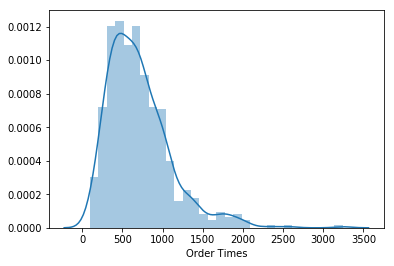

In [18]:
order_number_per_courier=[]
customer_ratings=pd.DataFrame({"Ratings":[],"Seconds":[]})
serving_times_per_courier=pd.DataFrame({"Order Times":[],"Order Dist. Time":[]})
for ratio in range(n_of_couriers):
    order_number_per_courier.append(len(courier_objects[ratio].order_serving_time))
    if len(courier_objects[ratio].order_serving_time) != 0:
        serving_times_per_courier=serving_times_per_courier.append(pd.DataFrame({"Order Times":courier_objects[ratio].order_serving_time,"Order Dist. Time":courier_objects[ratio].order_dist_time_history}),ignore_index = True)
for ratio in range(n_of_customers):
    if len(customer_objects[ratio].Rating) != 0:
        customer_ratings=customer_ratings.append(pd.DataFrame({"Ratings":customer_objects[ratio].Rating,"Seconds":customer_objects[ratio].order_arrival_time}),ignore_index = True)

        
        

print(order_number_per_courier)
print('Average Order number for couriers is {}'.format(np.mean(order_number_per_courier)))
print('--------------------------------------------------------------------------------')
print(serving_times_per_courier['Order Times'].values)
print('--------------------------------------------------------------------------------')
print('MEAN={}        STD={}'.format(serving_times_per_courier['Order Times'].mean(),serving_times_per_courier['Order Times'].std()))
print('MAX SERVICE TIME ={}'.format(serving_times_per_courier['Order Times'].max()))
sns.distplot(serving_times_per_courier['Order Times'],bins=30)

In [19]:
# 2. Create Figure
p = figure(plot_width = 600, plot_height = 400, title = 'Setup')
cust_x=[]
cust_y=[]
courier_x=[]
courier_y=[]
wh_x=[]
wh_y=[]
for i in customer_objects:
    cust_x.append(i.location_x)
    cust_y.append(i.location_y)
for i in courier_objects:
    courier_x.append(i.location_x)
    courier_y.append(i.location_y)
for i in warehouse_objects:
    wh_x.append(i.location_x)
    wh_y.append(i.location_y)

p.asterisk(wh_x, wh_y, color = 'blue',size=45)
p.circle(courier_x, courier_y, color = 'green', alpha = 0.5, size = 15)
#p.circle(cust_x, cust_y, color = 'red', alpha = 0.5, size = 15)
output_notebook()
show(p)

Loading BokehJS ...

In [20]:
hour_labels = ['00:00-01:00','01:00-02:00','02:00-03:00','03:00-04:00','04:00-05:00','05:00-06:00','06:00-07:00','07:00-08:00',
            '08:00-09:00','09:00-10:00','10:00-11:00','11:00-12:00','12:00-13:00','13:00-14:00','14:00-15:00','15:00-16:00',
            '16:00-17:00','17:00-18:00','18:00-19:00','19:00-20:00','20:00-21:00','21:00-22:00','22:00-23:00','23:00-24:00']
customer_ratings['Rating Hours']=pd.cut(customer_ratings['Seconds'],bins=range(0,86400+3600,3600),labels=hour_labels)
serving_times_per_courier['Serving Hours']=pd.cut(serving_times_per_courier['Order Dist. Time'],bins=range(0,86400+3600,3600),labels=hour_labels)

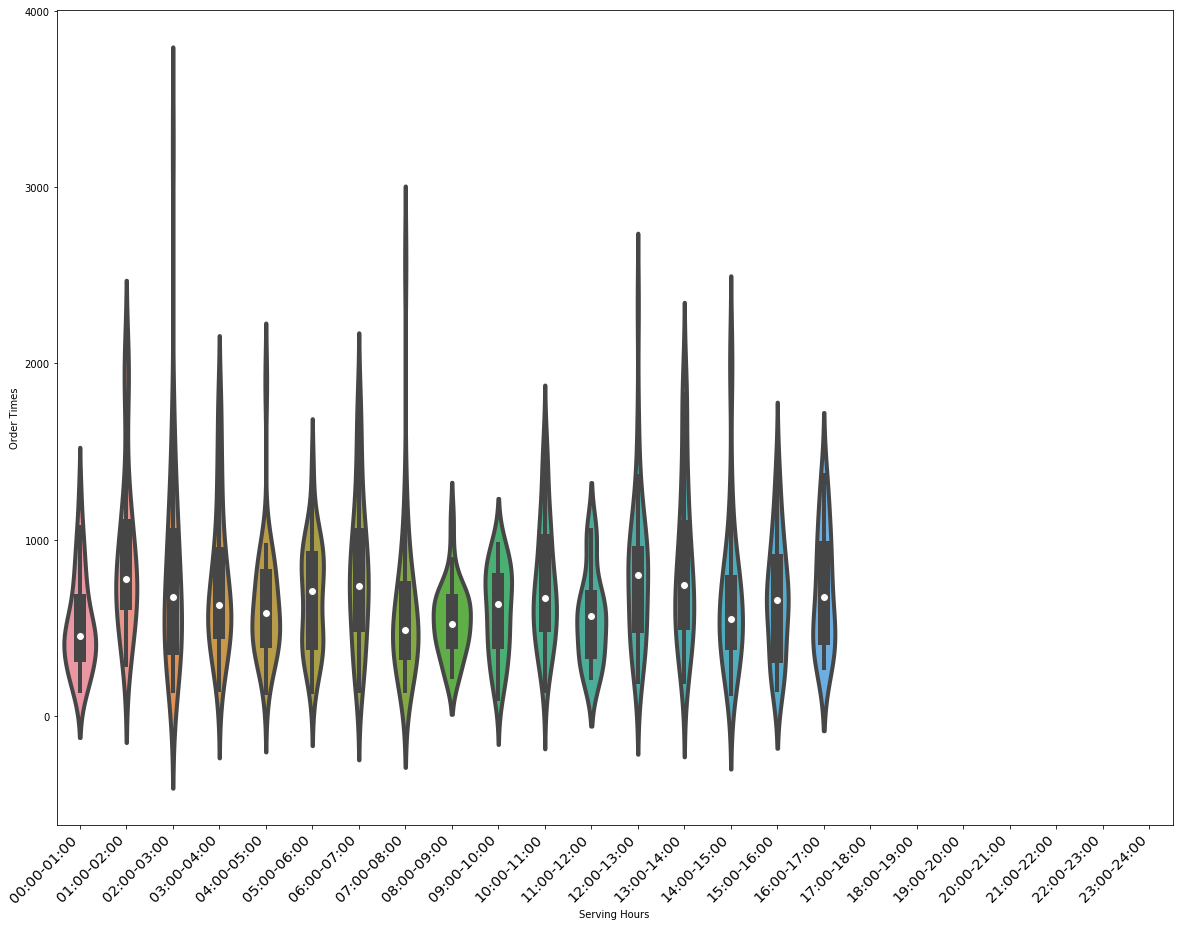

In [21]:
plt.pyplot.figure(figsize=(20,15))
chart=sns.violinplot(x=serving_times_per_courier["Serving Hours"], y=serving_times_per_courier["Order Times"], linewidth=4)
plt.pyplot.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.pyplot.show()

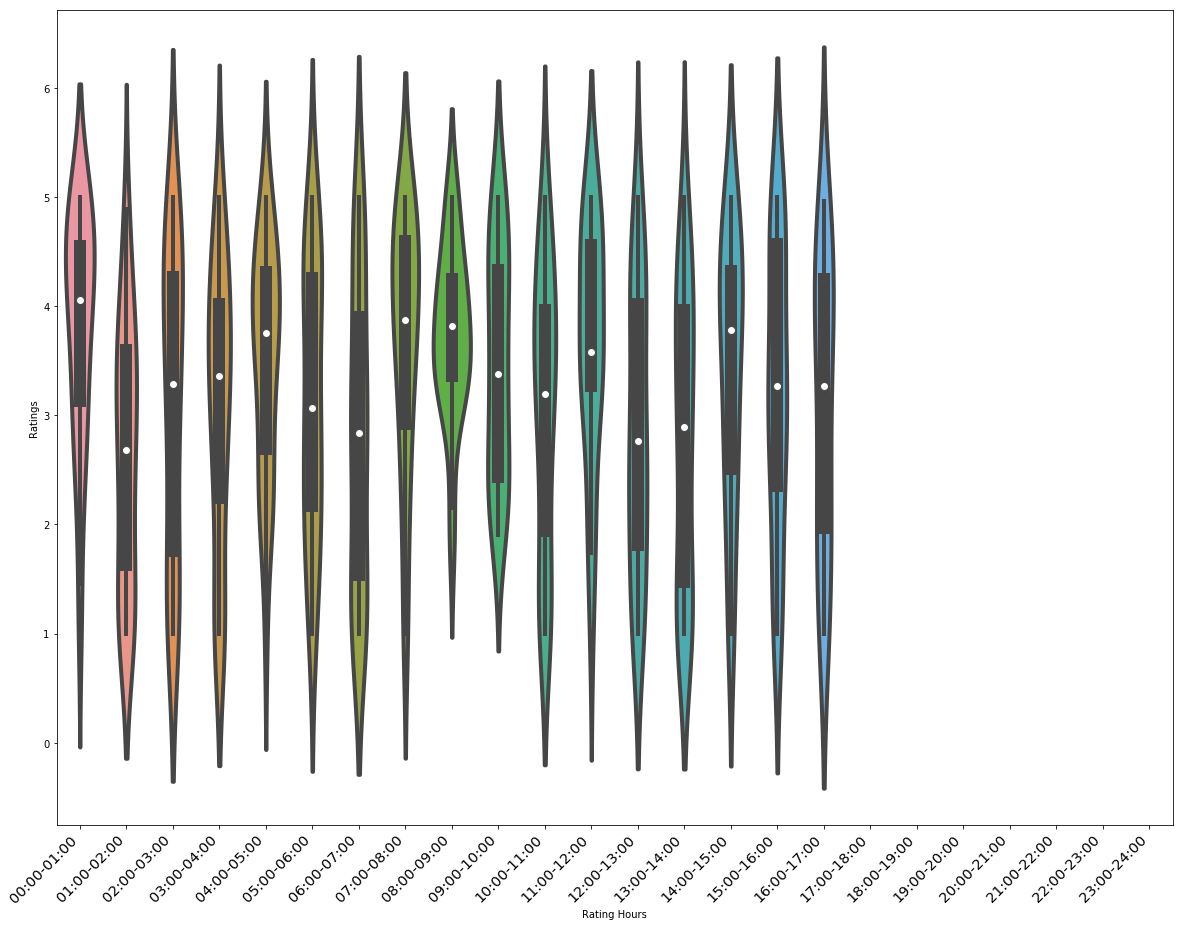

In [22]:
plt.pyplot.figure(figsize=(20,15))
chart=sns.violinplot(x=customer_ratings["Rating Hours"], y=customer_ratings["Ratings"], linewidth=4)
plt.pyplot.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.pyplot.show()

## In this simulation, warehouses are created in distance maximized locations and when an order comes from a customer, the orders are assigned the most nearest courier among the available ones .
## Besides,if a courier is available in a customer location in where that courier visited for an order purpose,the location of that courier may change in specific times.That is to say,the courier that delivered the order and available are sent to the nearest warehouse in a randomized order.

### In this simulation which lasts 17 hours,the inputs that I gave are;
    TOTAL CUSTOMERS  = 2000
    TOTAL COURÄ°ERS   = 15
    TOTAL WAREHOUSES = 4

### As a result of simulation, we can see that;
    Average order number for couriers is 39.6
    Service mean time is 707.84 and standart deviation of service times is 398.6